In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset from a CSV file
data = pd.read_csv('./file_pairs.csv')

# Split the data: 80% for training and 20% for validation
# Using a fixed random seed (42) ensures reproducibility of the split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Save the split datasets to new CSV files
train_data.to_csv('./extra_train_split.csv', index=False)
val_data.to_csv('./extra_val_split.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np

def create_test_set_with_candidates(val_data_path, output_path, num_candidates=20):
    # Load the data
    val_data = pd.read_csv(val_data_path)
    
    # For each row in the val_data, we'll keep the 'left' and 'right' columns and add 20 'candidate' columns
    all_right_images = val_data['right'].unique()
    
    new_data = []
    for _, row in val_data.iterrows():
        anchor = row['left']
        positive = row['right']

        # We add the positive as the first candidate (c0)
        candidates = [positive]

        # Randomly sample negative candidates
        negatives = np.random.choice(all_right_images, num_candidates-1, replace=False).tolist()

        # Ensure the positive is not in the negatives
        while positive in negatives:
            negatives = np.random.choice(all_right_images, num_candidates-1, replace=False).tolist()

        candidates.extend(negatives)

        new_row = {'left': anchor, 'right': positive}
        for idx, candidate in enumerate(candidates):
            new_row[f'c{idx}'] = candidate
        
        new_data.append(new_row)

    test_data_with_candidates = pd.DataFrame(new_data)
    test_data_with_candidates.to_csv(output_path, index=False)




In [ ]:
# Usage:
val_data_path = './extra_val_split.csv'
output_path = './extra_test_data_with_candidates.csv'
create_test_set_with_candidates(val_data_path, output_path)

In [ ]:
import tensorflow as tf
import pickle
import os
from tensorflow.keras import layers, Model, applications
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import cv2
import pandas as pd
from tensorflow.keras.models import load_model
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Multiply, GlobalAveragePooling2D, Dense, Conv2D, Activation
from sklearn.preprocessing import StandardScaler
import dlib
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, Multiply, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16


train_data = pd.read_csv('./train_split.csv')


val_data =pd.read_csv('./val_split.csv')

# Image data generator class for triplet loss
class TripletImageGenerator(Sequence):
    def __init__(self, dataframe, left_dir, right_dir, batch_size, img_size, model=None, embeddings_file=None, face_embedding=None, negative_nums=5,based_model = applications.ResNet50(include_top=False, weights='imagenet', input_shape=(244,244,3)),use_ImageDataGenerator = True):
        if embeddings_file:
            self.image_names, self.loaded_embeddings = load_embeddings(embeddings_file)
        else:
            self.image_names, self.loaded_embeddings = None, None
        self.dataframe = dataframe
        self.left_dir = left_dir
        self.right_dir = right_dir
        self.batch_size = batch_size
        self.img_size = img_size
        if use_ImageDataGenerator:
            self.datagen = ImageDataGenerator(
                rotation_range=20,       
                width_shift_range=0.2,    
                height_shift_range=0.2,   
                shear_range=0.2,          
                zoom_range=0.2,          
                horizontal_flip=True,     
                fill_mode='reflect',
            )

        else:
            self.datagen = ImageDataGenerator()
        self.model = model
        if model:
            self.embedding_model = create_custom_embedding(based_model,input_shape)
            inception_layer = model.layers[-2]
            self.embedding_model.set_weights(inception_layer.get_weights())
        left_images = dataframe['left'].apply(lambda fname: os.path.join('./train/left', fname + '.jpg')).tolist()
        right_images = dataframe['right'].apply(lambda fname: os.path.join('./train/right', fname + '.jpg')).tolist()

        all_image_paths = list(set(left_images + right_images))
        if face_embedding:
            self.precomputed_face_embeddings = {}
            for img_path in all_image_paths:
                self.precomputed_face_embeddings[img_path] = face_embedding[img_path]
        self.negative_nums = negative_nums

    def __len__(self):
        return len(self.dataframe) // self.batch_size

    
    def find_hard_negatives(self, anchor, positive_sample_name):
        if self.loaded_embeddings is None or self.image_names is None:
            raise ValueError("Embeddings are not loaded. Provide embeddings file during initialization.")


        anchor_embedding = self.embedding_model.predict([np.expand_dims(anchor, axis=0)])


        distances = np.linalg.norm(anchor_embedding - self.loaded_embeddings, axis=1)

        sorted_indices = np.argsort(distances)

        hard_negatives = []
        for idx in sorted_indices:
            if self.image_names[idx] != positive_sample_name:
                hard_negatives.append(self.image_names[idx])
            if len(hard_negatives) == self.negative_nums//2:  # Only pick 5 hardest negatives
                break

        remaining_images = set(self.image_names) - set(hard_negatives) - {positive_sample_name}
        random_negatives = np.random.choice(list(remaining_images), size=self.negative_nums-(self.negative_nums//2), replace=False)
        hard_negatives.extend(random_negatives)

        return hard_negatives

    def __getitem__(self, index):
        anchors = []
        positives = []
        all_negatives = []
        batch_data = self.dataframe.iloc[index * self.batch_size: (index + 1) * self.batch_size]

        for _, row in batch_data.iterrows():
            anchor_img_path = self.left_dir + '/' + row['left']+'.jpg'
            positive_img_path = self.right_dir + '/' + row['right']+'.jpg'
            
            anchor_img = cv2.imread(anchor_img_path)
            anchor_img = cv2.resize(anchor_img, self.img_size) / 255.0
            # anchor_img = preprocessing_black_borders(anchor_img)
            anchor_img = self.datagen.random_transform(anchor_img)

            positive_img = cv2.imread(positive_img_path)
            positive_img = cv2.resize(positive_img, self.img_size) / 255.0
            # positive_img = preprocessing_black_borders(positive_img)
            positive_img = self.datagen.random_transform(positive_img)

            
            
            if self.model: 
                hard_negatives = self.find_hard_negatives(anchor_img, row['right'])
                for j, neg_name in enumerate(hard_negatives):
                    neg_img_path = self.right_dir + '/' + neg_name+'.jpg'
                    neg_img = cv2.imread(neg_img_path)
                    neg_img = cv2.resize(neg_img, self.img_size) / 255.0
                    # neg_img = preprocessing_black_borders(neg_img)
                    neg_img = self.datagen.random_transform(neg_img)
                    all_negatives.append(neg_img)



                anchors.append(anchor_img)
                positives.append(positive_img)


            else:  
                negatives_for_this_pair = []
                all_negative_samples = set(self.dataframe['right'].unique()) - {row['right']}
                random_negatives = np.random.choice(list(all_negative_samples), size=self.negative_nums, replace=False)
                for neg_name in random_negatives:
                    negative_img_path = self.right_dir + '/' + neg_name + '.jpg'
                    negative_img = cv2.imread(negative_img_path)
                    negative_img = cv2.resize(negative_img, self.img_size) / 255.0
                    # negative_img = preprocessing_black_borders(negative_img)
                    negative_img = self.datagen.random_transform(negative_img)
                    negatives_for_this_pair.append(negative_img)

                all_negatives.extend(negatives_for_this_pair)
                anchors.append(anchor_img)
                positives.append(positive_img)



# Convert images to numpy arrays
        anchors = np.array(anchors, dtype='float32')
        positives = np.array(positives, dtype='float32')
        all_negatives = np.array(all_negatives, dtype='float32')

        negatives_split = np.array_split(all_negatives,self.negative_nums , axis=0)
        return [anchors, positives, *negatives_split], np.zeros(len(anchors))
# Function to remove black borders and stretch the image
def remove_and_stretch(img):
    h, w, _ = img.shape
    threshold = 30

    # Identify the non-black region (actual content)
    non_black_pixels = np.where((img[:, :, 0] > threshold) | (img[:, :, 1] > threshold) | (img[:, :, 2] > threshold))

    # The coordinates of non-black pixels
    non_black_coords = np.column_stack(non_black_pixels)

    # Find the bounding box coordinates
    x_min, y_min = non_black_coords.min(axis=0)
    x_max, y_max = non_black_coords.max(axis=0)

    # Crop the image to these coordinates (removing black borders)
    cropped_img = img[x_min:x_max+1, y_min:y_max+1]

    # Resize the cropped image back to the original dimensions
    stretched_img = cv2.resize(cropped_img, (w, h), interpolation=cv2.INTER_AREA)

    return stretched_img


    # Create an embedding model with attention mechanism
def create_custom_embedding(base_model, dropout_rate=0.3):

    attention = Conv2D(1, (1, 1), activation='sigmoid', name="attention_map")(base_model.output)
    attention_mul = Multiply(name="attention_multiply")([base_model.output, attention])
    

    pooled = GlobalAveragePooling2D()(attention_mul)
    

    dropped = layers.Dropout(dropout_rate)(pooled)
    
    model = Model(inputs=base_model.input, outputs=dropped)
    return model




# Triplet loss function with weighted negatives
def triplet_loss_with_weighted_negatives(y_true, y_pred, margin=1.0, num_negatives=5):
    embedding_size = y_pred.shape[1] // (num_negatives + 2)
    anchor, positive = y_pred[:, 0:embedding_size], y_pred[:, embedding_size:2*embedding_size]
    
    # Compute positive distance
    positive_distance = K.sum(K.square(anchor - positive), axis=1, keepdims=True)
    
    # Compute negative distances in a vectorized manner
    negatives_start = 2 * embedding_size
    negatives_end = negatives_start + num_negatives * embedding_size
    negatives_reshaped = K.reshape(y_pred[:, negatives_start:negatives_end], (-1, num_negatives, embedding_size))
    anchor_expanded = K.expand_dims(anchor, 1)
    negative_distances = K.sum(K.square(anchor_expanded - negatives_reshaped), axis=2)
    
    # Compute weights using softmax
    weights = tf.nn.softmax(-negative_distances, axis=1)
    
    # Compute losses for each negative sample
    losses = K.maximum(positive_distance - negative_distances + margin, 0.0)
    weighted_losses = weights * losses

    # Compute final loss
    combined_loss = K.mean(K.sum(weighted_losses, axis=1))
    return combined_loss








# Create a triplet network model that accepts multiple negative samples
def create_triplet_network_with_multiple_negatives(model,input_shape,negative_nums = 5):
    anchor_input = layers.Input(input_shape, name='anchor_input')
    positive_input = layers.Input(input_shape, name='positive_input')
    negative_inputs = [layers.Input(input_shape, name=f'negative_input_{i}') for i in range(negative_nums)]
    
    inception_embedding = create_custom_embedding(model)
    
    anchor_embedding = inception_embedding(anchor_input)
    positive_embedding = inception_embedding(positive_input)
    negative_embeddings = [inception_embedding(neg_input) for neg_input in negative_inputs]
    
    merged_vector = layers.concatenate([anchor_embedding, positive_embedding] + negative_embeddings, axis=-1, name='merged_layer')
    model = Model(inputs=[anchor_input, positive_input] + negative_inputs, outputs=merged_vector)
    
    return model





def precompute_embeddings(dataframe, right_dir, model, img_size):
    embeddings = []
    image_names = []
    
    for _, row in tqdm(dataframe.iterrows(),total=dataframe.shape[0], desc="Computing embeddings"):
        img_path = right_dir + '/' + row['right'] + '.jpg'
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        # img = preprocessing_black_borders(img)
        img = np.expand_dims(img, axis=0) / 255.0
        embedding = model.predict(img)
        embeddings.append(embedding)
        image_names.append(row['right'])
    
    return image_names, np.squeeze(np.array(embeddings))




def save_embeddings(image_names, embeddings, filename):
    np.savez(filename, image_names=image_names, embeddings=embeddings)


def load_embeddings(filename):
    data = np.load(filename)
    return data['image_names'], data['embeddings']

def compute_scores_with_embedding(embedding_model, anchor_image, candidate_image_paths, img_size=(224, 224)):
    # Resize and normalize the anchor image
    anchor_img = cv2.imread(anchor_image)
    anchor_img = cv2.resize(anchor_img, img_size) / 255.0
    # anchor_img = preprocessing_black_borders(anchor_img)
    anchor_embedding = embedding_model.predict(np.array([anchor_img]))

    # Load and preprocess all candidate images in one go
    candidate_images =[]
    for img in candidate_image_paths:
            tmp_image = cv2.resize(cv2.imread(img), img_size)
            candidate_images.append(tmp_image)
    # candidate_images = [cv2.resize(cv2.imread(img), img_size) for img in candidate_image_paths]
    candidate_images = np.array(candidate_images) / 255.0
    
    # Get embeddings for all candidate images in one go
    candidate_embeddings = embedding_model.predict(candidate_images)

    # Compute distances for all candidate images
    distances = -np.linalg.norm(anchor_embedding - candidate_embeddings, axis=1)

    return distances

def generate_confidence_csv(embedding_model, test_candidates_data, left_dir, right_dir, output_csv_path):
    """Generate a CSV file with confidence scores."""
    # Create a DataFrame to hold the results
    columns = ['left'] + [f'c{i}' for i in range(20)]
    results_df = pd.DataFrame(columns=columns)

    for _, row in tqdm(test_candidates_data.iterrows(), total=test_candidates_data.shape[0], desc="Processing rows"):
        anchor_image_path = left_dir + '/' + row['left'] + '.jpg'
        candidate_image_paths = [right_dir + '/' + img_name + '.jpg' for img_name in row.values[1:]]
        
        scores = compute_scores_with_embedding(embedding_model, anchor_image_path, candidate_image_paths)
        confidence_scores = softmax(scores)  # Convert scores to confidence values using softmax

        results = [row['left']] + list(confidence_scores)
        results_df.loc[len(results_df)] = results

    # Save the results to CSV
    results_df.to_csv(output_csv_path, index=False)

def compute_recall_at_k(embedding_model, val_data, left_dir, right_dir, k=1):
    recalls = []

    for _, row in val_data.iterrows():
        anchor_image_path = left_dir + '/' + row['left'] + '.jpg'
        positive_image_path = right_dir + '/' + row['right'] + '.jpg'
        candidate_image_paths = [right_dir + '/' + img_name + '.jpg' for img_name in row.values[1:]]

        scores = compute_scores_with_embedding(embedding_model, anchor_image_path, candidate_image_paths)
        top_k_indices = np.argsort(scores)[-k:]
        if row['right'] in np.array(candidate_image_paths)[top_k_indices]:
            recalls.append(1)
        else:
            recalls.append(0)

    return np.mean(recalls)
def get_embedding_model_from_triplet(triplet_model):

    inception_layer = triplet_model.layers[-2]  #
    

    embedding_model = Model(inputs=inception_layer.input, outputs=inception_layer.output)
    
    return embedding_model

def compute_test_accuracy(embedding_model, test_data, left_dir, right_dir):
    correct_predictions = 0

    for _, row in test_data.iterrows():
        anchor_image_path = left_dir + '/' + row['left'] + '.jpg'
        positive_image_path = right_dir + '/' + row['right'] + '.jpg'
        
        candidate_image_paths = [right_dir + '/' + img_name + '.jpg' for img_name in row.values[1:]]  

        scores = compute_scores_with_embedding(embedding_model, anchor_image_path, candidate_image_paths)
        best_match_index = np.argmax(scores) 
        best_match_image = candidate_image_paths[best_match_index]

        if best_match_image == positive_image_path:
            correct_predictions += 1

    accuracy = correct_predictions / len(test_data)
    return accuracy
def get_face_embedding(image_path):
    image = face_recognition.load_image_file(image_path)
    embeddings = face_recognition.face_encodings(image)

    if embeddings:
        return embeddings[0]
    else:
        return np.zeros((128,))
def get_shape_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(image, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, 2, 1)

    if contours:
        cnt = contours[0]
        moments = cv2.moments(cnt)
        hu_moments = cv2.HuMoments(moments)
        return np.reshape(hu_moments, (7,))
    else:
        return np.zeros((7,))

In [2]:
from keras.callbacks import Callback

class TopNAccuracyCallback(Callback):
    def __init__(self, embedding_model,validation_data, left_dir, right_dir, N=1):
        super().__init__()
        self.validation_data = validation_data
        self.left_dir = left_dir
        self.right_dir = right_dir
        self.N = N
        self.embedding_model = embedding_model

    def on_epoch_end(self, epoch, logs=None):
        topN_correct_predictions = 0
        total_samples = len(self.validation_data)

        for _, row in self.validation_data.iterrows():
            anchor_image_path = self.left_dir + '/' + row['left'] + '.jpg'
            positive_image_path = self.right_dir + '/' + row['right'] + '.jpg'
            
            candidate_image_paths = [self.right_dir + '/' + img_name + '.jpg' for img_name in row.values[1:]]

            scores = compute_scores_with_embedding(
                self.embedding_model,
                anchor_image_path,
                candidate_image_paths
            )

            topN_indices = np.argsort(scores)[-self.N:]
            if candidate_image_paths.index(positive_image_path) in topN_indices:
                topN_correct_predictions += 1

        topN_accuracy = topN_correct_predictions / total_samples
        
        logs[f"val_top_{self.N}_acc"] = topN_accuracy
        print(f"\nEpoch {epoch+1}: val_top_{self.N}_acc = {topN_accuracy:.4f}")


In [55]:
batch_size =32
img_size = (224, 224)

left_dir = './train/left'
right_dir = './train/right'

input_shape = (224, 224, 3)
test_data = pd.read_csv('./val_split_with_candidates.csv') 


In [20]:
models_list = [applications.DenseNet121, applications.InceptionV3, applications.ResNet50, applications.EfficientNetB0]
model_names = ["DenseNet121", "InceptionV3", "ResNet50", "EfficientNetB0"]

Epoch 1/10


2023-10-18 12:28:56.745178: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56/56 [==============================] - ETA: 0s - loss: 17.5122

2023-10-18 12:29:52.125961: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 1.78561, saving model to /saved_model/best_DenseNet121_zening.h5
56/56 [==============================] - 71s 983ms/step - loss: 17.5122 - val_loss: 1.7856 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 0.9896
Epoch 2: val_loss improved from 1.78561 to 0.86722, saving model to /saved_model/best_DenseNet121_zening.h5
56/56 [==============================] - 50s 880ms/step - loss: 0.9896 - val_loss: 0.8672 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 0.8526
Epoch 3: val_loss improved from 0.86722 to 0.79498, saving model to /saved_model/best_DenseNet121_zening.h5
56/56 [==============================] - 53s 946ms/step - loss: 0.8526 - val_loss: 0.7950 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 0.8837
Epoch 4: val_loss did not improve from 0.79498
56/56 [==============================] - 51s 903ms/step - loss: 0.8837 - val_loss: 0.8021 - lr: 0

2023-10-18 12:38:39.914685: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56/56 [==============================] - ETA: 0s - loss: 1.7767

2023-10-18 12:39:33.225836: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 0.99363, saving model to /saved_model/best_InceptionV3_zening.h5
56/56 [==============================] - 66s 955ms/step - loss: 1.7767 - val_loss: 0.9936 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 0.9965
Epoch 2: val_loss improved from 0.99363 to 0.98823, saving model to /saved_model/best_InceptionV3_zening.h5
56/56 [==============================] - 50s 888ms/step - loss: 0.9965 - val_loss: 0.9882 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 0.9858
Epoch 3: val_loss did not improve from 0.98823
56/56 [==============================] - 48s 841ms/step - loss: 0.9858 - val_loss: 0.9898 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 1.0053
Epoch 4: val_loss did not improve from 0.98823

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
56/56 [==============================] - 50s 892ms/step - loss: 1.0053 - val_loss

2023-10-18 12:47:59.598499: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56/56 [==============================] - ETA: 0s - loss: 10.9235

2023-10-18 12:48:48.719589: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 0.99896, saving model to /saved_model/best_ResNet50_zening.h5
56/56 [==============================] - 58s 883ms/step - loss: 10.9235 - val_loss: 0.9990 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 0.9570
Epoch 2: val_loss improved from 0.99896 to 0.99895, saving model to /saved_model/best_ResNet50_zening.h5
56/56 [==============================] - 50s 885ms/step - loss: 0.9570 - val_loss: 0.9990 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 0.9500
Epoch 3: val_loss improved from 0.99895 to 0.99334, saving model to /saved_model/best_ResNet50_zening.h5
56/56 [==============================] - 49s 874ms/step - loss: 0.9500 - val_loss: 0.9933 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 0.8998
Epoch 4: val_loss improved from 0.99334 to 0.96051, saving model to /saved_model/best_ResNet50_zening.h5
56/56 [==============================] - 49s 866

2023-10-18 12:57:07.597564: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56/56 [==============================] - ETA: 0s - loss: 1.7227

2023-10-18 12:58:01.308349: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 0.98763, saving model to /saved_model/best_EfficientNetB0_zening.h5
56/56 [==============================] - 68s 943ms/step - loss: 1.7227 - val_loss: 0.9876 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 0.8169
Epoch 2: val_loss improved from 0.98763 to 0.98185, saving model to /saved_model/best_EfficientNetB0_zening.h5
56/56 [==============================] - 51s 902ms/step - loss: 0.8169 - val_loss: 0.9819 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 0.7429
Epoch 3: val_loss did not improve from 0.98185
56/56 [==============================] - 49s 859ms/step - loss: 0.7429 - val_loss: 1.0323 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 0.6631
Epoch 4: val_loss improved from 0.98185 to 0.72219, saving model to /saved_model/best_EfficientNetB0_zening.h5
56/56 [==============================] - 49s 855ms/step - loss: 0.6631 - val_loss: 0.7222

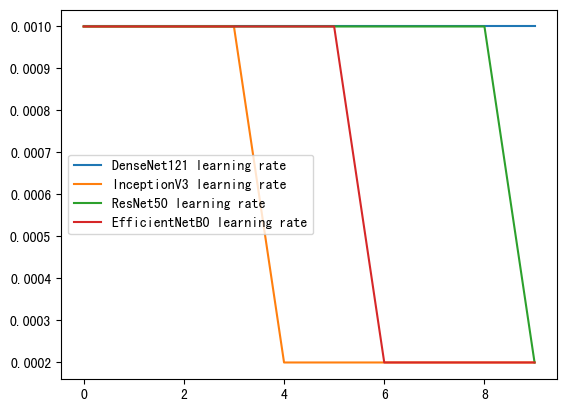

In [55]:
# Test for the different model 


nums = 1
accuracies = []
histories = []

for model_func, model_name in zip(models_list, model_names):

    
    based_model = model_func(include_top=False, weights='imagenet', input_shape=input_shape)
    model = create_triplet_network_with_multiple_negatives(model =based_model ,input_shape=input_shape,negative_nums = nums )
    optimizer = Adam(learning_rate=0.001)
    def custom_triplet_loss(y_true, y_pred):
        return triplet_loss_with_weighted_negatives(y_true, y_pred, num_negatives = nums)
    embedding_model = get_embedding_model_from_triplet(model)
    optimizer = Adam(learning_rate=0.001)
    top_2_acc_callback = TopNAccuracyCallback(embedding_model,test_data,left_dir,right_dir,N=2)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)
    model.compile(optimizer=optimizer, loss=custom_triplet_loss)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    
    best_model_path = f"/saved_model/best_{model_name}_zening.h5"
    checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    val_generator = TripletImageGenerator(val_data, left_dir, right_dir, batch_size, img_size,negative_nums = nums,use_ImageDataGenerator = False)
    train_generator = TripletImageGenerator(train_data, left_dir, right_dir, batch_size, img_size,negative_nums = nums,use_ImageDataGenerator = True)



    
    history = model.fit(train_generator, epochs=10, verbose=1,validation_data=val_generator, callbacks=[checkpoint, reduce_lr])
    histories.append(history)
    

    
    model_path = f"/saved_model/{model_name}_zening.h5"
    model.save(model_path)


    
    loaded_model = load_model(best_model_path, custom_objects={'custom_triplet_loss': custom_triplet_loss})
    embedding_model = get_embedding_model_from_triplet(loaded_model)
    accuracy = compute_test_accuracy(embedding_model, test_data, left_dir, right_dir)
    accuracies.append(accuracy)
    print(f"Accuracy for {model_name} on test set: {accuracy:.2%}")


    
import pandas as pd
for history, model_name in zip(histories, model_names):
    plt.plot(history.history['lr'], label=f"{model_name} learning rate")
plt.legend()
plt.show()


In [80]:
import json

data = {
    "accuracies": accuracies
}


for history, model_name in zip(histories, model_names):
    data[f"Train Loss {model_name}"] = history.history['loss']
    data[f"Val Loss {model_name}"] = history.history['val_loss']
with open('training_data_select_model.json', 'w') as f:
    json.dump(data, f)

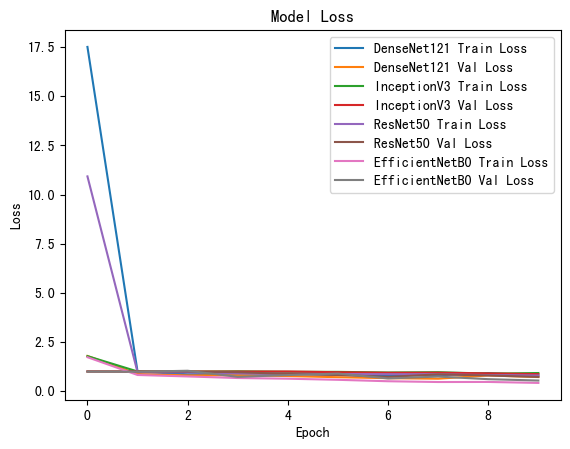

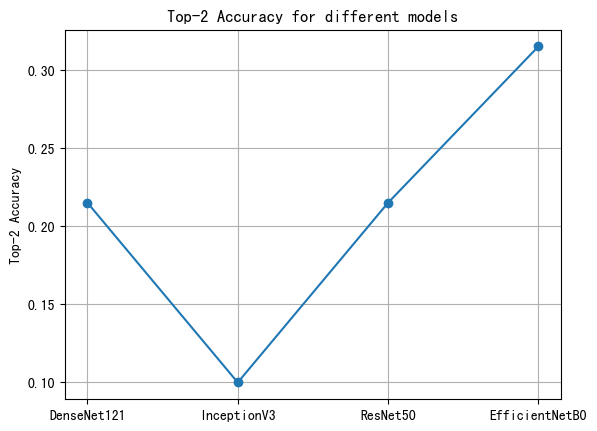

In [32]:
import json
with open('training_data_select_model.json', 'r') as file:
    training_data_select_model = json.load(file)
accuracies = training_data_select_model['accuracies']

for model_name in model_names:
    plt.plot(training_data_select_model[f"Train Loss {model_name}"], label=f"{model_name} Train Loss")
    plt.plot(training_data_select_model[f"Val Loss {model_name}"], label=f"{model_name} Val Loss")

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig('./plots/model_select_loss.png')
plt.show()

plt.plot(model_names, accuracies, marker='o', linestyle='-')
plt.title('Top-2 Accuracy for different models')
plt.ylabel('Top-2 Accuracy')
plt.xticks(model_names)
plt.grid(True)
plt.savefig('./plots/model_select_accuracy.png')
plt.show()

In [35]:
nums = [1,2,3,4,5]

In [62]:
# Test for the different number of negatives 

models_list = [applications.EfficientNetB0]
model_names = ["EfficientNetB0"]

nums = [1,2,3,4,5]
accuracies_nums_negative = []
histories_nums_negative = []

for model_func, model_name in zip(models_list, model_names):
    for i in nums:
        based_model = model_func(include_top=False, weights='imagenet', input_shape=input_shape)
        model = create_triplet_network_with_multiple_negatives(model =based_model ,input_shape=input_shape,negative_nums = i )
        optimizer = Adam(learning_rate=0.001)
        def custom_triplet_loss(y_true, y_pred):
            return triplet_loss_with_weighted_negatives(y_true, y_pred, num_negatives = i)
        embedding_model = get_embedding_model_from_triplet(model)
        optimizer = Adam(learning_rate=0.001)
        top_2_acc_callback = TopNAccuracyCallback(embedding_model,test_data,left_dir,right_dir,N=2)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
        model.compile(optimizer=optimizer, loss=custom_triplet_loss)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        
        best_model_path = f"./saved_model/best_{model_name}_num_negative_{i}_zening.h5"
        checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        val_generator = TripletImageGenerator(val_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = False)
        train_generator = TripletImageGenerator(train_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = True)



        
        history = model.fit(train_generator, epochs=100, verbose=1,validation_data=val_generator, callbacks=[checkpoint, early_stopping,reduce_lr])
        histories_nums_negative.append(history)


        
        model_path = f"./saved_model/{model_name}_num_negative_{i}_zening.h5"
        model.save(model_path)


        
        loaded_model = load_model(best_model_path, custom_objects={'custom_triplet_loss': custom_triplet_loss})
        embedding_model = get_embedding_model_from_triplet(loaded_model)
        accuracy = compute_test_accuracy(embedding_model, test_data, left_dir, right_dir)
        accuracies_nums_negative.append(accuracy)
        print(f"Accuracy for {model_name}_num_negative_{i} on test set: {accuracy:.2%}")


        



Epoch 1/100


2023-10-18 13:40:58.143640: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56/56 [==============================] - ETA: 0s - loss: 1.6100

2023-10-18 13:41:51.636086: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 0.99555, saving model to ./saved_model/best_EfficientNetB0_num_negative_1_zening.h5
56/56 [==============================] - 67s 951ms/step - loss: 1.6100 - val_loss: 0.9956 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.8985
Epoch 2: val_loss did not improve from 0.99555
56/56 [==============================] - 48s 848ms/step - loss: 0.8985 - val_loss: 1.1623 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 0.7560
Epoch 3: val_loss improved from 0.99555 to 0.78123, saving model to ./saved_model/best_EfficientNetB0_num_negative_1_zening.h5
56/56 [==============================] - 51s 901ms/step - loss: 0.7560 - val_loss: 0.7812 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - ETA: 0s - loss: 0.6865
Epoch 4: val_loss did not improve from 0.78123
56/56 [==============================] - 50s 875ms/step - loss: 0.6865 - val_loss: 0.9575 - lr: 0.0010
Epoch 5/100
56/

2023-10-18 14:14:42.108935: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56/56 [==============================] - ETA: 0s - loss: 2.3972

2023-10-18 14:15:50.494212: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 1.83473, saving model to ./saved_model/best_EfficientNetB0_num_negative_2_zening.h5
56/56 [==============================] - 86s 1s/step - loss: 2.3972 - val_loss: 1.8347 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.8950
Epoch 2: val_loss improved from 1.83473 to 1.03772, saving model to ./saved_model/best_EfficientNetB0_num_negative_2_zening.h5
56/56 [==============================] - 66s 1s/step - loss: 0.8950 - val_loss: 1.0377 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 0.8359
Epoch 3: val_loss improved from 1.03772 to 0.72756, saving model to ./saved_model/best_EfficientNetB0_num_negative_2_zening.h5
56/56 [==============================] - 66s 1s/step - loss: 0.8359 - val_loss: 0.7276 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - ETA: 0s - loss: 0.7301
Epoch 4: val_loss did not improve from 0.72756
56/56 [==============================] - 63s 1s

2023-10-18 15:08:11.684081: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56/56 [==============================] - ETA: 0s - loss: 1.6633

2023-10-18 15:09:34.627156: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 0.99518, saving model to ./saved_model/best_EfficientNetB0_num_negative_3_zening.h5
56/56 [==============================] - 107s 1s/step - loss: 1.6633 - val_loss: 0.9952 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.9026
Epoch 2: val_loss did not improve from 0.99518
56/56 [==============================] - 78s 1s/step - loss: 0.9026 - val_loss: 1.0198 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 0.8320
Epoch 3: val_loss improved from 0.99518 to 0.90261, saving model to ./saved_model/best_EfficientNetB0_num_negative_3_zening.h5
56/56 [==============================] - 79s 1s/step - loss: 0.8320 - val_loss: 0.9026 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - ETA: 0s - loss: 0.7597
Epoch 4: val_loss did not improve from 0.90261
56/56 [==============================] - 83s 1s/step - loss: 0.7597 - val_loss: 0.9308 - lr: 0.0010
Epoch 5/100
56/56 [=======

2023-10-18 15:59:10.441213: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56/56 [==============================] - ETA: 0s - loss: 2.2391

2023-10-18 16:00:49.065302: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 1.06737, saving model to ./saved_model/best_EfficientNetB0_num_negative_4_zening.h5
56/56 [==============================] - 124s 2s/step - loss: 2.2391 - val_loss: 1.0674 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.9645
Epoch 2: val_loss improved from 1.06737 to 0.87139, saving model to ./saved_model/best_EfficientNetB0_num_negative_4_zening.h5
56/56 [==============================] - 94s 2s/step - loss: 0.9645 - val_loss: 0.8714 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 0.8714
Epoch 3: val_loss improved from 0.87139 to 0.79350, saving model to ./saved_model/best_EfficientNetB0_num_negative_4_zening.h5
56/56 [==============================] - 92s 2s/step - loss: 0.8714 - val_loss: 0.7935 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - ETA: 0s - loss: 0.8324
Epoch 4: val_loss improved from 0.79350 to 0.76673, saving model to ./saved_model/best_Effici

2023-10-18 16:52:26.818589: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56/56 [==============================] - ETA: 0s - loss: 1.7521

2023-10-18 16:54:19.588303: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 1.02772, saving model to ./saved_model/best_EfficientNetB0_num_negative_5_zening.h5
56/56 [==============================] - 142s 2s/step - loss: 1.7521 - val_loss: 1.0277 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.9252
Epoch 2: val_loss improved from 1.02772 to 0.93078, saving model to ./saved_model/best_EfficientNetB0_num_negative_5_zening.h5
56/56 [==============================] - 109s 2s/step - loss: 0.9252 - val_loss: 0.9308 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 0.8683
Epoch 3: val_loss did not improve from 0.93078
56/56 [==============================] - 110s 2s/step - loss: 0.8683 - val_loss: 1.1778 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - ETA: 0s - loss: 0.8010
Epoch 4: val_loss improved from 0.93078 to 0.72086, saving model to ./saved_model/best_EfficientNetB0_num_negative_5_zening.h5
56/56 [==============================] - 110

AttributeError: 'list' object has no attribute 'history'

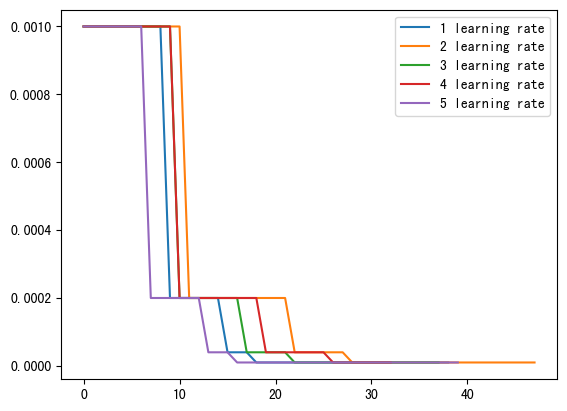

In [63]:
for history, model_name in zip(histories_nums_negative, nums):
    plt.plot(history.history['lr'], label=f"{model_name} learning rate")
plt.legend()
plt.show()

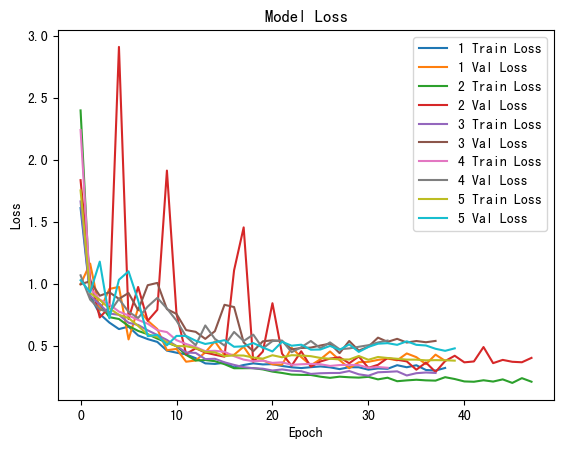

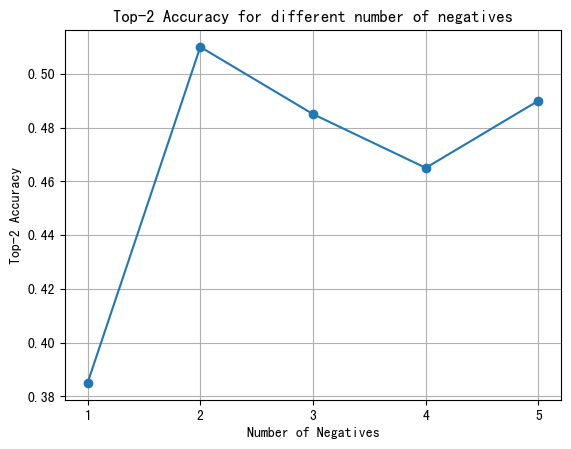

In [64]:


for history, model_name in zip(histories_nums_negative, nums):
    plt.plot(history.history['loss'], label=f"{model_name} Train Loss")
    plt.plot(history.history['val_loss'], label=f"{model_name} Val Loss")

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()



plt.plot(nums, accuracies_nums_negative, marker='o', linestyle='-')
plt.title('Top-2 Accuracy for different number of negatives')
plt.ylabel('Top-2 Accuracy')
plt.xlabel('Number of Negatives')
plt.xticks(nums)
plt.grid(True)
plt.show()


In [81]:
import json

data = {
    "accuracies": accuracies_nums_negative
}



for idx, history in enumerate(histories_nums_negative):
    data[f"Train Loss {nums[idx]}"] = history.history['loss']
    data[f"Val Loss {nums[idx]}"] = history.history['val_loss']

with open('training_data_select_negative_sampple.json', 'w') as f:
    json.dump(data, f)


In [33]:
import json
with open('training_data_select_negative_sampple.json', 'r') as file:
    training_data_select_negative_sampple = json.load(file)

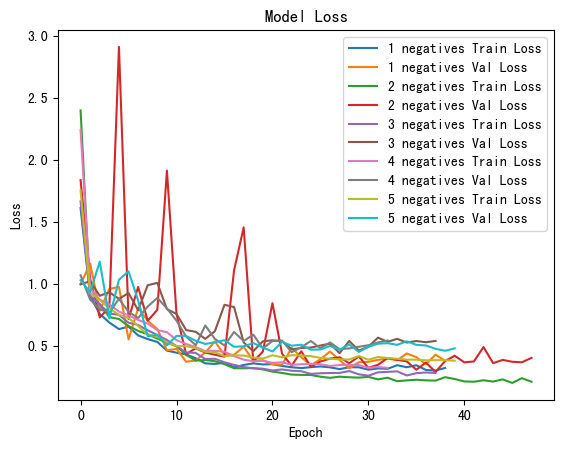

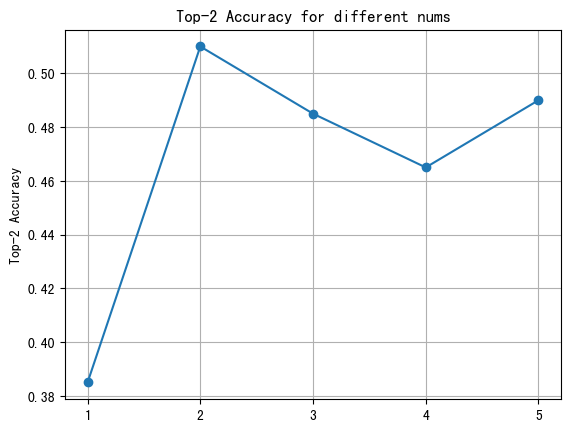

In [37]:
import json
with open('training_data_select_negative_sampple.json', 'r') as file:
    training_data_select_negative_sampple = json.load(file)
accuracies = training_data_select_negative_sampple['accuracies']


for num in nums:
    plt.plot(training_data_select_negative_sampple[f"Train Loss {num}"], label=f"{num} negatives Train Loss")
    plt.plot(training_data_select_negative_sampple[f"Val Loss {num}"], label=f"{num} negatives Val Loss")

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig('./plots/num_negative_loss.png')
plt.show()


plt.plot(nums, accuracies, marker='o', linestyle='-')
plt.title('Top-2 Accuracy for different nums')
plt.ylabel('Top-2 Accuracy')
plt.xticks(nums)
plt.grid(True)
plt.savefig('./plots/num_negative_accuracy.png')
plt.show()

In [130]:
class TripletImageGenerator_with_process(Sequence):
    def __init__(self, dataframe, left_dir, right_dir, batch_size, img_size, model=None, embeddings_file=None, face_embedding=None, negative_nums=5,based_model = applications.ResNet50(include_top=False, weights='imagenet', input_shape=(244,244,3)),use_ImageDataGenerator = True):
        if embeddings_file:
            self.image_names, self.loaded_embeddings = load_embeddings(embeddings_file)
        else:
            self.image_names, self.loaded_embeddings = None, None
        self.dataframe = dataframe
        self.left_dir = left_dir
        self.right_dir = right_dir
        self.batch_size = batch_size
        self.img_size = img_size
        if use_ImageDataGenerator:
            self.datagen = ImageDataGenerator(
                rotation_range=20,        
                width_shift_range=0.2,    
                height_shift_range=0.2,   
                shear_range=0.2,          
                zoom_range=0.2,          
                horizontal_flip=True,     
                fill_mode='reflect',
            )

        else:
            self.datagen = ImageDataGenerator()
        self.model = model
        if model:
            self.embedding_model = create_custom_embedding(based_model,input_shape)
            inception_layer = model.layers[-2]
            self.embedding_model.set_weights(inception_layer.get_weights())
        left_images = dataframe['left'].apply(lambda fname: os.path.join('./train/left', fname + '.jpg')).tolist()
        right_images = dataframe['right'].apply(lambda fname: os.path.join('./train/right', fname + '.jpg')).tolist()

        all_image_paths = list(set(left_images + right_images))
        if face_embedding:
            self.precomputed_face_embeddings = {}
            for img_path in all_image_paths:
                self.precomputed_face_embeddings[img_path] = face_embedding[img_path]
        self.negative_nums = negative_nums

    def __len__(self):
        return len(self.dataframe) // self.batch_size

    
    def find_hard_negatives(self, anchor, positive_sample_name):
        if self.loaded_embeddings is None or self.image_names is None:
            raise ValueError("Embeddings are not loaded. Provide embeddings file during initialization.")


        anchor_embedding = self.embedding_model.predict([np.expand_dims(anchor, axis=0)])

  
        distances = np.linalg.norm(anchor_embedding - self.loaded_embeddings, axis=1)

        sorted_indices = np.argsort(distances)

        hard_negatives = []
        for idx in sorted_indices:
            if self.image_names[idx] != positive_sample_name:
                hard_negatives.append(self.image_names[idx])
            if len(hard_negatives) == self.negative_nums//2:  # Only pick 5 hardest negatives
                break

        remaining_images = set(self.image_names) - set(hard_negatives) - {positive_sample_name}
        random_negatives = np.random.choice(list(remaining_images), size=5, replace=False)
        hard_negatives.extend(random_negatives)

        return hard_negatives
    def remove_and_stretch(self,img):
        h, w, _ = img.shape
        threshold = 30/225
        # Identify the non-black region (actual content)
        non_black_pixels = np.where((img[:, :, 0] > threshold) | (img[:, :, 1] > threshold) | (img[:, :, 2] > threshold))
        # The coordinates of non-black pixels
        non_black_coords = np.column_stack(non_black_pixels)

        # Find the bounding box coordinates
        x_min, y_min = non_black_coords.min(axis=0)
        x_max, y_max = non_black_coords.max(axis=0)

        # Crop the image to these coordinates (removing black borders)
        cropped_img = img[x_min:x_max+1, y_min:y_max+1]

        # Resize the cropped image back to the original dimensions
        stretched_img = cv2.resize(cropped_img, (w, h), interpolation=cv2.INTER_AREA)
        
        return stretched_img
    def __getitem__(self, index):
        anchors = []
        positives = []
        all_negatives = []
        batch_data = self.dataframe.iloc[index * self.batch_size: (index + 1) * self.batch_size]

        for _, row in batch_data.iterrows():
            anchor_img_path = self.left_dir + '/' + row['left']+'.jpg'
            positive_img_path = self.right_dir + '/' + row['right']+'.jpg'
            
            anchor_img = cv2.imread(anchor_img_path)
            anchor_img = cv2.resize(anchor_img, self.img_size) / 255.0
            anchor_img = self.remove_and_stretch(anchor_img)
            anchor_img = self.datagen.random_transform(anchor_img)

            positive_img = cv2.imread(positive_img_path)
            positive_img = cv2.resize(positive_img, self.img_size) / 255.0
            positive_img = self.remove_and_stretch(positive_img)
            positive_img = self.datagen.random_transform(positive_img)

            
            
            if self.model: 
                hard_negatives = self.find_hard_negatives(anchor_img, row['right'])
                for j, neg_name in enumerate(hard_negatives):
                    neg_img_path = self.right_dir + '/' + neg_name+'.jpg'
                    neg_img = cv2.imread(neg_img_path)
                    neg_img = cv2.resize(neg_img, self.img_size) / 255.0
                    neg_img = self.remove_and_stretch(neg_img)
                    neg_img = self.datagen.random_transform(neg_img)
                    all_negatives.append(neg_img)


                # Now, add random negatives
                remaining_images = set(self.image_names) - set(hard_negatives) - {row['right']}
                random_negatives = np.random.choice(list(remaining_images), size=self.negative_nums-(self.negative_nums//2), replace=False)  # size=5 to pick 5 random negatives

                for random_neg_name in random_negatives:
                    neg_img_path = self.right_dir + '/' + random_neg_name+'.jpg'
                    neg_img = cv2.imread(neg_img_path)
                    neg_img = cv2.resize(neg_img, self.img_size) / 255.0
                    neg_img = self.remove_and_stretch(neg_img)
                    neg_img = self.datagen.random_transform(neg_img) 
                    all_negatives.append(cv2.resize(neg_img, self.img_size))


                anchors.append(anchor_img)
                positives.append(positive_img)


            else:  
                negatives_for_this_pair = []
                all_negative_samples = set(self.dataframe['right'].unique()) - {row['right']}
                random_negatives = np.random.choice(list(all_negative_samples), size=self.negative_nums, replace=False)
                for neg_name in random_negatives:
                    negative_img_path = self.right_dir + '/' + neg_name + '.jpg'
                    negative_img = cv2.imread(negative_img_path)
                    negative_img = cv2.resize(negative_img, self.img_size) / 255.0
                    negative_img = self.remove_and_stretch(negative_img)
                    negative_img = self.datagen.random_transform(negative_img)
                    negatives_for_this_pair.append(negative_img)

                all_negatives.extend(negatives_for_this_pair)
                anchors.append(anchor_img)
                positives.append(positive_img)


# Convert images to numpy arrays
        anchors = np.array(anchors, dtype='float32')
        positives = np.array(positives, dtype='float32')
        all_negatives = np.array(all_negatives, dtype='float32')

        negatives_split = np.array_split(all_negatives,self.negative_nums , axis=0)

        return [anchors, positives, *negatives_split], np.zeros(len(anchors))

In [38]:
generators = ['TripletImageGenerator_with_process','TripletImageGenerator']

In [113]:
import json

data = {
    "accuracies": accuracies_preprocess
}

for history,g in zip(histories_preprocess,generators):
    data[f"Train Loss {g}"] = history.history['loss']
    data[f"Val Loss {g}"] = history.history['val_loss']

with open('training_data_select_preprocess.json', 'w') as f:
    json.dump(data, f)


In [112]:
# test whethe use the perprocess
models_list = [applications.EfficientNetB0]
model_names = ["EfficientNetB0"]
generators = ['TripletImageGenerator_with_process','TripletImageGenerator']

nums = [2]
accuracies_preprocess = []
histories_preprocess = []

for model_func, model_name in zip(models_list, model_names):
    for generator in generators:
        i = 2

        
        based_model = model_func(include_top=False, weights='imagenet', input_shape=input_shape)
        model = create_triplet_network_with_multiple_negatives(model =based_model ,input_shape=input_shape,negative_nums = i )
        optimizer = Adam(learning_rate=0.001)
        def custom_triplet_loss(y_true, y_pred):
            return triplet_loss_with_weighted_negatives(y_true, y_pred, num_negatives = i)
        embedding_model = get_embedding_model_from_triplet(model)
        optimizer = Adam(learning_rate=0.001)
        top_2_acc_callback = TopNAccuracyCallback(embedding_model,test_data,left_dir,right_dir,N=2)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
        model.compile(optimizer=optimizer, loss=custom_triplet_loss)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        
        best_model_path = f"./saved_model/best_{model_name}_num_negative_2_{generator}_zening.h5"
        checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        if generator == 'TripletImageGenerator':
            val_generator = TripletImageGenerator(val_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = False)
            train_generator = TripletImageGenerator(train_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = True)
        else:
            val_generator = TripletImageGenerator_with_process(val_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = False)
            train_generator = TripletImageGenerator_with_process(train_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = True)



            
        history = model.fit(train_generator, epochs=100, verbose=1,validation_data=val_generator, callbacks=[checkpoint, early_stopping,reduce_lr])
        histories_preprocess.append(history)


        
        model_path = f"./saved_model/{model_name}_num_negative_2_{generator}_zening.h5"
        model.save(model_path)

        
        loaded_model = load_model(best_model_path, custom_objects={'custom_triplet_loss': custom_triplet_loss})
        embedding_model = get_embedding_model_from_triplet(loaded_model)
        accuracy = compute_test_accuracy(embedding_model, test_data, left_dir, right_dir)
        accuracies_preprocess.append(accuracy)
        print(f"Accuracy for {model_name}_num_negative_2_{generator} on test set: {accuracy:.2%}")





Epoch 1/100


2023-10-18 20:29:41.346924: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56/56 [==============================] - ETA: 0s - loss: 1.9929

2023-10-18 20:31:01.557616: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 0.98917, saving model to ./saved_model/best_EfficientNetB0_num_negative_2_TripletImageGenerator_with_process_zening.h5
56/56 [==============================] - 100s 1s/step - loss: 1.9929 - val_loss: 0.9892 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.9527
Epoch 2: val_loss improved from 0.98917 to 0.92915, saving model to ./saved_model/best_EfficientNetB0_num_negative_2_TripletImageGenerator_with_process_zening.h5
56/56 [==============================] - 81s 1s/step - loss: 0.9527 - val_loss: 0.9292 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 0.8819
Epoch 3: val_loss improved from 0.92915 to 0.85182, saving model to ./saved_model/best_EfficientNetB0_num_negative_2_TripletImageGenerator_with_process_zening.h5
56/56 [==============================] - 78s 1s/step - loss: 0.8819 - val_loss: 0.8518 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - ETA: 0s - l

2023-10-18 21:21:20.470206: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56/56 [==============================] - ETA: 0s - loss: 1.9878

2023-10-18 21:22:28.788211: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 81458233344 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 0.96480, saving model to ./saved_model/best_EfficientNetB0_num_negative_2_TripletImageGenerator_zening.h5
56/56 [==============================] - 86s 1s/step - loss: 1.9878 - val_loss: 0.9648 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.8885
Epoch 2: val_loss improved from 0.96480 to 0.89877, saving model to ./saved_model/best_EfficientNetB0_num_negative_2_TripletImageGenerator_zening.h5
56/56 [==============================] - 61s 1s/step - loss: 0.8885 - val_loss: 0.8988 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 0.8297
Epoch 3: val_loss did not improve from 0.89877
56/56 [==============================] - 62s 1s/step - loss: 0.8297 - val_loss: 0.9211 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - ETA: 0s - loss: 0.7621
Epoch 4: val_loss did not improve from 0.89877
56/56 [==============================] - 63s 1s/step - loss: 0.7621 - val_loss: 0.9

In [82]:
# build trained model for hard negative
batch_size =32
img_size = (224, 224)

left_dir = './train/left'
right_dir = './train/right'
# best_model_path = "/saved_model/RN_50_16_best_nearest_zening_noaugr.h5"
input_shape = (224, 224, 3)
test_data = pd.read_csv('./val_split_with_candidates.csv') 
models_list = [applications.EfficientNetB0]
model_names = ["EfficientNetB0"]
generators = ['TripletImageGenerator_with_process']

nums = [2]
accuracies_preprocess = []
histories_preprocess = []

for model_func, model_name in zip(models_list, model_names):
    for generator in generators:
        i = 2

        
        based_model = model_func(include_top=False, weights='imagenet', input_shape=input_shape)
        model = create_triplet_network_with_multiple_negatives(model =based_model ,input_shape=input_shape,negative_nums = i )
        optimizer = Adam(learning_rate=0.001)
        def custom_triplet_loss(y_true, y_pred):
            return triplet_loss_with_weighted_negatives(y_true, y_pred, num_negatives = i)
        embedding_model = get_embedding_model_from_triplet(model)
        optimizer = Adam(learning_rate=0.001)
        top_2_acc_callback = TopNAccuracyCallback(embedding_model,test_data,left_dir,right_dir,N=2)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
        model.compile(optimizer=optimizer, loss=custom_triplet_loss)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
 

        best_model_path = f"./saved_model/batch_32_fix_best_{model_name}_num_negative_2_{generator}_zening.h5"
        checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        if generator == 'TripletImageGenerator':
            val_generator = TripletImageGenerator(val_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = False)
            train_generator = TripletImageGenerator(train_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = True)
        else:
            val_generator = TripletImageGenerator_with_process(val_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = False)
            train_generator = TripletImageGenerator_with_process(train_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = True)



            
        history = model.fit(train_generator, epochs=100, verbose=1,validation_data=val_generator, callbacks=[checkpoint, early_stopping,reduce_lr])
        histories_preprocess.append(history)


        
        model_path = f"./saved_model/batch_32_fix_{model_name}_num_negative_2_{generator}_zening.h5"
        model.save(model_path)


        
        loaded_model = load_model(best_model_path, custom_objects={'custom_triplet_loss': custom_triplet_loss})
        embedding_model = get_embedding_model_from_triplet(loaded_model)
        accuracy = compute_test_accuracy(embedding_model, test_data, left_dir, right_dir)
        accuracies_preprocess.append(accuracy)
        print(f"Accuracy for {model_name}_num_negative_2_{generator} on test set: {accuracy:.2%}")


        



Epoch 1/100


2023-10-19 10:37:06.630253: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82832916480 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56/56 [==============================] - ETA: 0s - loss: 2.5479

2023-10-19 10:38:15.801853: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82832916480 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 1.01879, saving model to ./saved_model/batch_32_fix_best_EfficientNetB0_num_negative_2_TripletImageGenerator_zening.h5
56/56 [==============================] - 86s 1s/step - loss: 2.5479 - val_loss: 1.0188 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.9247
Epoch 2: val_loss improved from 1.01879 to 0.87087, saving model to ./saved_model/batch_32_fix_best_EfficientNetB0_num_negative_2_TripletImageGenerator_zening.h5
56/56 [==============================] - 66s 1s/step - loss: 0.9247 - val_loss: 0.8709 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 0.8357
Epoch 3: val_loss improved from 0.87087 to 0.80544, saving model to ./saved_model/batch_32_fix_best_EfficientNetB0_num_negative_2_TripletImageGenerator_zening.h5
56/56 [==============================] - 61s 1s/step - loss: 0.8357 - val_loss: 0.8054 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - ETA: 0s - lo

In [84]:
# build a more finely tuned trained model for hard negative
batch_size =8
img_size = (224, 224)

left_dir = './train/left'
right_dir = './train/right'
# best_model_path = "/saved_model/RN_50_16_best_nearest_zening_noaugr.h5"
input_shape = (224, 224, 3)
test_data = pd.read_csv('./val_split_with_candidates.csv') 
models_list = [applications.EfficientNetB0]
model_names = ["EfficientNetB0"]
generators = ['TripletImageGenerator_with_process']

nums = [2]
accuracies_preprocess = []
histories_preprocess = []

for model_func, model_name in zip(models_list, model_names):
    for generator in generators:
        i = 2

        
        based_model = model_func(include_top=False, weights='imagenet', input_shape=input_shape)
        model = create_triplet_network_with_multiple_negatives(model =based_model ,input_shape=input_shape,negative_nums = i )
        optimizer = Adam(learning_rate=0.001)
        def custom_triplet_loss(y_true, y_pred):
            return triplet_loss_with_weighted_negatives(y_true, y_pred, num_negatives = i)
        embedding_model = get_embedding_model_from_triplet(model)
        optimizer = Adam(learning_rate=0.001)
        top_2_acc_callback = TopNAccuracyCallback(embedding_model,test_data,left_dir,right_dir,N=2)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
        model.compile(optimizer=optimizer, loss=custom_triplet_loss)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        
        best_model_path = f"./saved_model/batch_8_fix_best_{model_name}_num_negative_2_{generator}_zening.h5"
        checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        if generator == 'TripletImageGenerator':
            val_generator = TripletImageGenerator(val_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = False)
            train_generator = TripletImageGenerator(train_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = True)
        else:
            val_generator = TripletImageGenerator_with_process(val_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = False)
            train_generator = TripletImageGenerator_with_process(train_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = True)



            
        history = model.fit(train_generator, epochs=100, verbose=1,validation_data=val_generator, callbacks=[checkpoint, early_stopping,reduce_lr])
        histories_preprocess.append(history)


        
        model_path = f"./saved_model/batch_8_fix_{model_name}_num_negative_2_{generator}_zening.h5"
        model.save(model_path)

        
        loaded_model = load_model(best_model_path, custom_objects={'custom_triplet_loss': custom_triplet_loss})
        embedding_model = get_embedding_model_from_triplet(loaded_model)
        accuracy = compute_test_accuracy(embedding_model, test_data, left_dir, right_dir)
        accuracies_preprocess.append(accuracy)
        print(f"Accuracy for {model_name}_num_negative_2_{generator} on test set: {accuracy:.2%}")


        



Epoch 1/100


2023-10-19 11:23:57.732906: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82832916480 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/225 [==============================] - ETA: 0s - loss: 1.3240

2023-10-19 11:25:24.001751: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82832916480 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 1.07212, saving model to ./saved_model/batch_8_fix_best_EfficientNetB0_num_negative_2_TripletImageGenerator_zening.h5
225/225 [==============================] - 104s 384ms/step - loss: 1.3240 - val_loss: 1.0721 - lr: 0.0010
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: 0.8683
Epoch 2: val_loss did not improve from 1.07212
225/225 [==============================] - 81s 358ms/step - loss: 0.8683 - val_loss: 3953.7861 - lr: 0.0010
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 0.8569
Epoch 3: val_loss improved from 1.07212 to 0.97894, saving model to ./saved_model/batch_8_fix_best_EfficientNetB0_num_negative_2_TripletImageGenerator_zening.h5
225/225 [==============================] - 79s 351ms/step - loss: 0.8569 - val_loss: 0.9789 - lr: 0.0010
Epoch 4/100
225/225 [==============================] - ETA: 0s - loss: 0.8173
Epoch 4: val_loss did not improve from 0.97894
225/225 [=========================

In [85]:
import json

data = {
    "accuracies": accuracies_preprocess
}


for history,g in zip(histories_preprocess,generators):
    data[f"Train Loss {g}"] = history.history['loss']
    data[f"Val Loss {g}"] = history.history['val_loss']

with open('batch_8_training_data_select_preprocess.json', 'w') as f:
    json.dump(data, f)

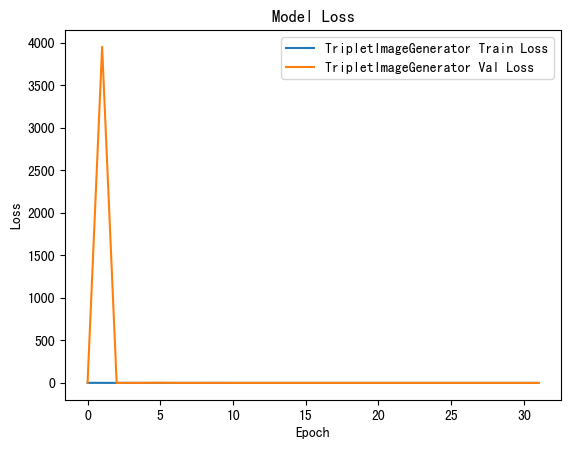

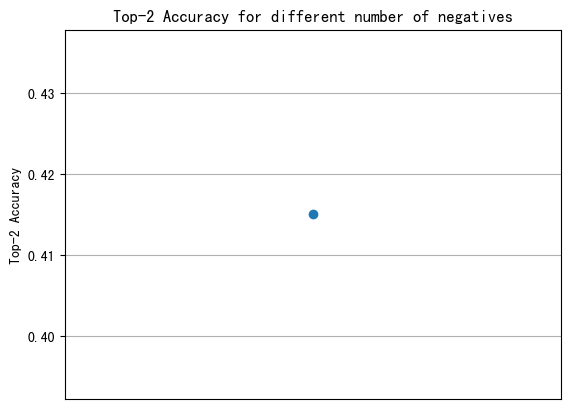

In [86]:
for history,g in zip(histories_preprocess,generators):
    plt.plot(history.history['loss'], label=f"{g} Train Loss")
    plt.plot(history.history['val_loss'], label=f"{g} Val Loss")

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

plt.plot(generators, accuracies_preprocess, marker='o', linestyle='-')
plt.title('Top-2 Accuracy for different number of negatives')
plt.ylabel('Top-2 Accuracy')
# plt.xlabel('Number of Negatives')
plt.xticks(nums)
plt.grid(True)
plt.show()

In [ ]:
batch_size =8
img_size = (224, 224)

left_dir = './train/left'
right_dir = './train/right'
# best_model_path = "/saved_model/RN_50_16_best_nearest_zening_noaugr.h5"
input_shape = (224, 224, 3)

In [ ]:
# finalize the model for generate hard negatives

models_list = [applications.EfficientNetB0]
model_names = ["EfficientNetB0"]
generators = ['TripletImageGenerator_with_process']
train_data_hard = pd.read_csv('./train.csv')
nums = [2]
accuracies_preprocess = []
histories_preprocess = []

for model_func, model_name in zip(models_list, model_names):
    for generator in generators:
        i = 2

        based_model = model_func(include_top=False, weights='imagenet', input_shape=input_shape)
        model = create_triplet_network_with_multiple_negatives(model =based_model ,input_shape=input_shape,negative_nums = i )
        optimizer = Adam(learning_rate=0.001)
        def custom_triplet_loss(y_true, y_pred):
            return triplet_loss_with_weighted_negatives(y_true, y_pred, num_negatives = i)
        embedding_model = get_embedding_model_from_triplet(model)
        optimizer = Adam(learning_rate=0.001)
        top_2_acc_callback = TopNAccuracyCallback(embedding_model,test_data,left_dir,right_dir,N=2)
        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
        model.compile(optimizer=optimizer, loss=custom_triplet_loss)

        early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

        best_model_path = f"./saved_model/best_{model_name}_num_negative_2_{generator}_zening.h5"
        checkpoint = ModelCheckpoint(best_model_path, monitor='loss', verbose=1, save_best_only=True, mode='min')

        # val_generator = TripletImageGenerator(val_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = False)
        train_generator = TripletImageGenerator(train_data_hard, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = True)

  
        history = model.fit(train_generator, epochs=100, verbose=1, callbacks=[checkpoint, early_stopping,reduce_lr])
        histories_preprocess.append(history)


        model_path = f"./saved_model/{model_name}_num_negative_2_{generator}_zening.h5"
        model.save(model_path)

  
        loaded_model = load_model(best_model_path, custom_objects={'custom_triplet_loss': custom_triplet_loss})
        embedding_model = get_embedding_model_from_triplet(loaded_model)
        accuracy = compute_test_accuracy(embedding_model, test_data, left_dir, right_dir)
        accuracies_preprocess.append(accuracy)
        print(f"Accuracy for {model_name}_num_negative_2_{generator} on test set: {accuracy:.2%}")





In [56]:
# save hard neagtive emmbeddings
train_data = pd.read_csv('./train_split.csv')
loaded_model = load_model("./saved_model/best_EfficientNetB0_num_negative_2_TripletImageGenerator_zening.h5", custom_objects={'custom_triplet_loss': custom_triplet_loss})
embedding_model = get_embedding_model_from_triplet(loaded_model)
image_names, embeddings = precompute_embeddings(train_data, right_dir, embedding_model, img_size)
save_embeddings(image_names, embeddings, 'embeddings_10——19.npz')

Computing embeddings: 100%|██████████| 1800/1800 [02:18<00:00, 13.04it/s]


In [ ]:
# test wth triple loss margin  [1,2,3,4]
batch_size =32
img_size = (224, 224)

left_dir = './train/left'
right_dir = './train/right'
# best_model_path = "/saved_model/RN_50_16_best_nearest_zening_noaugr.h5"
input_shape = (224, 224, 3)
test_data = pd.read_csv('./val_split_with_candidates.csv') 
models_list = [applications.EfficientNetB0]
model_names = ["EfficientNetB0"]
generators = ['TripletImageGenerator_with_process']
train_data_hard = pd.read_csv('./train_split.csv')
nums = [2]
margins =[1,2,3,4]
accuracies_margins = []
histories_margins = []

for model_func, model_name in zip(models_list, model_names):
    for generator in generators:
        for margin in margins:
            i = 2

            based_model = model_func(include_top=False, weights='imagenet', input_shape=input_shape)
            model = create_triplet_network_with_multiple_negatives(model =based_model ,input_shape=input_shape,negative_nums = i )
            optimizer = Adam(learning_rate=0.001)
            def custom_triplet_loss(y_true, y_pred):
                return triplet_loss_with_weighted_negatives(y_true, y_pred, margin =margin,num_negatives = i)
            embedding_model = get_embedding_model_from_triplet(model)
            optimizer = Adam(learning_rate=0.001)
            loaded_model = load_model("./saved_model/EfficientNetB0_num_negative_2_TripletImageGenerator_zening.h5", custom_objects={'custom_triplet_loss': custom_triplet_loss})
            top_2_acc_callback = TopNAccuracyCallback(embedding_model,test_data,left_dir,right_dir,N=2)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
            model.compile(optimizer=optimizer, loss=custom_triplet_loss)

            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
   
            best_model_path = f"./saved_model/hard_best_{model_name}_num_negative_2_{generator}_margin_{margin}_zening.h5"
            checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

            val_generator = TripletImageGenerator_with_process(val_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = False)
            train_generator = TripletImageGenerator_with_process(train_data, left_dir, right_dir, batch_size, img_size,model=loaded_model,embeddings_file='embeddings_10——19.npz',based_model = based_model ,negative_nums = i,use_ImageDataGenerator = True)


            history = model.fit(train_generator, epochs=100, verbose=1, validation_data=val_generator, callbacks=[checkpoint, early_stopping,reduce_lr])
            histories_margins.append(history)

            model_path = f"./hard_saved_model/hard_{model_name}_num_negative_2_{generator}_margin_{margin}zening.h5"
            model.save(model_path)

            loaded_model = load_model(best_model_path, custom_objects={'custom_triplet_loss': custom_triplet_loss})
            embedding_model = get_embedding_model_from_triplet(loaded_model)
            accuracy = compute_test_accuracy(embedding_model, test_data, left_dir, right_dir)
            accuracies_margins.append(accuracy)
            print(f"Accuracy for {model_name}_num_negative_2_{generator}_margin_{margin} on test set: {accuracy:.2%}")




In [94]:
# test wth triple loss margin  [1,2,3,4]
batch_size =32
img_size = (224, 224)

left_dir = './train/left'
right_dir = './train/right'
# best_model_path = "/saved_model/RN_50_16_best_nearest_zening_noaugr.h5"
input_shape = (224, 224, 3)
test_data = pd.read_csv('./val_split_with_candidates.csv') 
models_list = [applications.EfficientNetB0]
model_names = ["EfficientNetB0"]
generators = ['TripletImageGenerator_with_process']
train_data_hard = pd.read_csv('./train_split.csv')
nums = [2]
margins =[2]
accuracies_margins = []
histories_margins = []

for model_func, model_name in zip(models_list, model_names):
    for generator in generators:
        for margin in margins:
            i = 2

            based_model = model_func(include_top=False, weights='imagenet', input_shape=input_shape)
            model = create_triplet_network_with_multiple_negatives(model =based_model ,input_shape=input_shape,negative_nums = i )
            optimizer = Adam(learning_rate=0.001)
            def custom_triplet_loss(y_true, y_pred):
                return triplet_loss_with_weighted_negatives(y_true, y_pred, margin =margin,num_negatives = i)
            embedding_model = get_embedding_model_from_triplet(model)
            optimizer = Adam(learning_rate=0.0001)
            loaded_model = load_model("./saved_model/EfficientNetB0_num_negative_2_TripletImageGenerator_zening.h5", custom_objects={'custom_triplet_loss': custom_triplet_loss})
            top_2_acc_callback = TopNAccuracyCallback(embedding_model,test_data,left_dir,right_dir,N=2)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1)
            model.compile(optimizer=optimizer, loss=custom_triplet_loss)

            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            best_model_path = f"./saved_model/hard_best_{model_name}_num_negative_2_{generator}_margin_{margin}_zening.h5"
            checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

            val_generator = TripletImageGenerator_with_process(val_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = False)
            train_generator = TripletImageGenerator_with_process(train_data, left_dir, right_dir, batch_size, img_size,model=loaded_model,embeddings_file='embeddings_10——19.npz',based_model = based_model ,negative_nums = i,use_ImageDataGenerator = True)


            history = model.fit(train_generator, epochs=100, verbose=1, validation_data=val_generator, callbacks=[checkpoint, early_stopping,reduce_lr])
            histories_margins.append(history)


            model_path = f"./hard_saved_model/hard_{model_name}_num_negative_2_{generator}_margin_{margin}zening.h5"
            model.save(model_path)


            loaded_model = load_model(best_model_path, custom_objects={'custom_triplet_loss': custom_triplet_loss})
            embedding_model = get_embedding_model_from_triplet(loaded_model)
            accuracy = compute_test_accuracy(embedding_model, test_data, left_dir, right_dir)
            accuracies_margins.append(accuracy)
            print(f"Accuracy for {model_name}_num_negative_2_{generator}_margin_{margin} on test set: {accuracy:.2%}")




Epoch 1/100


2023-10-19 17:06:56.068742: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82832916480 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56/56 [==============================] - ETA: 0s - loss: 0.8250

2023-10-19 17:11:24.626395: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82832916480 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 0.55039, saving model to ./saved_model/hard_best_EfficientNetB0_num_negative_2_TripletImageGenerator_margin_2_zening.h5
56/56 [==============================] - 286s 5s/step - loss: 0.8250 - val_loss: 0.5504 - lr: 1.0000e-04
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.5929
Epoch 2: val_loss improved from 0.55039 to 0.43128, saving model to ./saved_model/hard_best_EfficientNetB0_num_negative_2_TripletImageGenerator_margin_2_zening.h5
56/56 [==============================] - 266s 5s/step - loss: 0.5929 - val_loss: 0.4313 - lr: 1.0000e-04
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 0.5182
Epoch 3: val_loss did not improve from 0.43128
56/56 [==============================] - 267s 5s/step - loss: 0.5182 - val_loss: 0.4838 - lr: 1.0000e-04
Epoch 4/100
56/56 [==============================] - ETA: 0s - loss: 0.3669
Epoch 4: val_loss did not improve from 0.43128

Epoch 4: ReduceLROnPlateau reducing lea

In [96]:
# test wth triple loss margin  [1,2,3,4]
batch_size =32
img_size = (224, 224)

left_dir = './train/left'
right_dir = './train/right'
# best_model_path = "/saved_model/RN_50_16_best_nearest_zening_noaugr.h5"
input_shape = (224, 224, 3)
test_data = pd.read_csv('./val_split_with_candidates.csv') 
models_list = [applications.EfficientNetB0]
model_names = ["EfficientNetB0"]
generators = ['TripletImageGenerator_with_process']
train_data_hard = pd.read_csv('./train_split.csv')
nums = [2]
margins =[3,4]
accuracies_margins = []
histories_margins = []

for model_func, model_name in zip(models_list, model_names):
    for generator in generators:
        for margin in margins:
            i = 2

            based_model = model_func(include_top=False, weights='imagenet', input_shape=input_shape)
            model = create_triplet_network_with_multiple_negatives(model =based_model ,input_shape=input_shape,negative_nums = i )
            optimizer = Adam(learning_rate=0.001)
            def custom_triplet_loss(y_true, y_pred):
                return triplet_loss_with_weighted_negatives(y_true, y_pred, margin =margin,num_negatives = i)
            embedding_model = get_embedding_model_from_triplet(model)
            optimizer = Adam(learning_rate=0.0001)
            loaded_model = load_model("./saved_model/EfficientNetB0_num_negative_2_TripletImageGenerator_zening.h5", custom_objects={'custom_triplet_loss': custom_triplet_loss})
            top_2_acc_callback = TopNAccuracyCallback(embedding_model,test_data,left_dir,right_dir,N=2)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0000001, verbose=1)
            model.compile(optimizer=optimizer, loss=custom_triplet_loss)

            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            best_model_path = f"./saved_model/hard_best_{model_name}_num_negative_2_{generator}_margin_{margin}_zening.h5"
            checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

            val_generator = TripletImageGenerator_with_process(val_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = False)
            train_generator = TripletImageGenerator_with_process(train_data, left_dir, right_dir, batch_size, img_size,model=loaded_model,embeddings_file='embeddings_10——19.npz',based_model = based_model ,negative_nums = i,use_ImageDataGenerator = True)


            history = model.fit(train_generator, epochs=100, verbose=1, validation_data=val_generator, callbacks=[checkpoint, early_stopping,reduce_lr])
            histories_margins.append(history)


            model_path = f"./hard_saved_model/hard_{model_name}_num_negative_2_{generator}_margin_{margin}zening.h5"
            model.save(model_path)

            loaded_model = load_model(best_model_path, custom_objects={'custom_triplet_loss': custom_triplet_loss})
            embedding_model = get_embedding_model_from_triplet(loaded_model)
            accuracy = compute_test_accuracy(embedding_model, test_data, left_dir, right_dir)
            accuracies_margins.append(accuracy)
            print(f"Accuracy for {model_name}_num_negative_2_{generator}_margin_{margin} on test set: {accuracy:.2%}")




Epoch 1/100


2023-10-19 18:19:05.951826: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82832916480 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56/56 [==============================] - ETA: 0s - loss: 1.8361

2023-10-19 18:23:45.541144: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82832916480 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 0.97395, saving model to ./saved_model/hard_best_EfficientNetB0_num_negative_2_TripletImageGenerator_margin_3_zening.h5
56/56 [==============================] - 298s 5s/step - loss: 1.8361 - val_loss: 0.9740 - lr: 1.0000e-04
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 1.0280
Epoch 2: val_loss improved from 0.97395 to 0.75318, saving model to ./saved_model/hard_best_EfficientNetB0_num_negative_2_TripletImageGenerator_margin_3_zening.h5
56/56 [==============================] - 271s 5s/step - loss: 1.0280 - val_loss: 0.7532 - lr: 1.0000e-04
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 0.8762
Epoch 3: val_loss did not improve from 0.75318
56/56 [==============================] - 265s 5s/step - loss: 0.8762 - val_loss: 1.1451 - lr: 1.0000e-04
Epoch 4/100
56/56 [==============================] - ETA: 0s - loss: 0.8031
Epoch 4: val_loss did not improve from 0.75318

Epoch 4: ReduceLROnPlateau reducing lea

2023-10-19 19:41:32.272798: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82832916480 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56/56 [==============================] - ETA: 0s - loss: 2.4521

2023-10-19 19:45:59.474952: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82832916480 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 1.22930, saving model to ./saved_model/hard_best_EfficientNetB0_num_negative_2_TripletImageGenerator_margin_4_zening.h5
56/56 [==============================] - 289s 5s/step - loss: 2.4521 - val_loss: 1.2293 - lr: 1.0000e-04
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 1.4441
Epoch 2: val_loss improved from 1.22930 to 1.22115, saving model to ./saved_model/hard_best_EfficientNetB0_num_negative_2_TripletImageGenerator_margin_4_zening.h5
56/56 [==============================] - 259s 5s/step - loss: 1.4441 - val_loss: 1.2211 - lr: 1.0000e-04
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 1.2338
Epoch 3: val_loss improved from 1.22115 to 1.08757, saving model to ./saved_model/hard_best_EfficientNetB0_num_negative_2_TripletImageGenerator_margin_4_zening.h5
56/56 [==============================] - 273s 5s/step - loss: 1.2338 - val_loss: 1.0876 - lr: 1.0000e-04
Epoch 4/100
56/56 [============================

In [119]:
# test wth triple loss margin  [1,2,3,4]
batch_size =32
img_size = (224, 224)

left_dir = './train/left'
right_dir = './train/right'
# best_model_path = "/saved_model/RN_50_16_best_nearest_zening_noaugr.h5"
input_shape = (224, 224, 3)
test_data = pd.read_csv('./val_split_with_candidates.csv') 
# save hard neagtive emmbeddings
train_data = pd.read_csv('./train.csv')
def custom_triplet_loss(y_true, y_pred):
    return triplet_loss_with_weighted_negatives(y_true, y_pred, margin =4,num_negatives = 2)
loaded_model = load_model("./saved_model/hard_best_EfficientNetB0_num_negative_2_TripletImageGenerator_margin_4_zening.h5", custom_objects={'custom_triplet_loss': custom_triplet_loss})
embedding_model = get_embedding_model_from_triplet(loaded_model)
image_names, embeddings = precompute_embeddings(train_data, right_dir, embedding_model, img_size)
save_embeddings(image_names, embeddings, 'embeddings_margin_4.npz')

Computing embeddings: 100%|██████████| 2000/2000 [02:32<00:00, 13.14it/s]


In [ ]:
# margin 4 model
batch_size =8
img_size = (224, 224)

left_dir = './train/left'
right_dir = './train/right'
# best_model_path = "/saved_model/RN_50_16_best_nearest_zening_noaugr.h5"
input_shape = (224, 224, 3)
test_data = pd.read_csv('./val_split_with_candidates.csv') 
models_list = [applications.EfficientNetB0]
model_names = ["EfficientNetB0"]
generators = ['TripletImageGenerator_with_process']
train_data_hard = pd.read_csv('./train_split.csv')
nums = [2]
margins =[4]
accuracies_final = []
histories_final = []

for model_func, model_name in zip(models_list, model_names):
    for generator in generators:
        for margin in margins:
            i = 2

            based_model = model_func(include_top=False, weights='imagenet', input_shape=input_shape)
            model = create_triplet_network_with_multiple_negatives(model =based_model ,input_shape=input_shape,negative_nums = i )
            def custom_triplet_loss(y_true, y_pred):
                return triplet_loss_with_weighted_negatives(y_true, y_pred, margin =margin,num_negatives = i)
            embedding_model = get_embedding_model_from_triplet(model)
            optimizer = Adam(learning_rate=0.001)
            loaded_model = load_model("./saved_model/hard_best_EfficientNetB0_num_negative_2_TripletImageGenerator_margin_4_zening.h5", custom_objects={'custom_triplet_loss': custom_triplet_loss})
            top_2_acc_callback = TopNAccuracyCallback(embedding_model,test_data,left_dir,right_dir,N=2)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1)
            model.compile(optimizer=optimizer, loss=custom_triplet_loss)

            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            best_model_path = f"./saved_model/final_best_margin_{margin}.h5"
            checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

            val_generator = TripletImageGenerator_with_process(val_data, left_dir, right_dir, batch_size, img_size,negative_nums = i,use_ImageDataGenerator = False)
            train_generator = TripletImageGenerator_with_process(train_data_hard, left_dir, right_dir, batch_size, img_size,model=loaded_model,embeddings_file='embeddings_margin_4.npz',based_model = based_model ,negative_nums = i,use_ImageDataGenerator = True)


            history = model.fit(train_generator, epochs=50, verbose=1,validation_data=val_generator,  callbacks=[checkpoint, early_stopping,reduce_lr])
            histories_final.append(history)


            model_path = f"./hard_saved_model/final_margin_{margin}.h5"
            model.save(model_path)


            loaded_model = load_model(best_model_path, custom_objects={'custom_triplet_loss': custom_triplet_loss})
            embedding_model = get_embedding_model_from_triplet(loaded_model)
            accuracy = compute_test_accuracy(embedding_model, test_data, left_dir, right_dir)
            accuracies_final.append(accuracy)
            print(f"Accuracy for {model_name}_num_negative_2_{generator}_margin_{margin} on test set: {accuracy:.2%}")




Epoch 1/50


2023-10-20 06:22:48.408759: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82832916480 bandwidth: 1935360000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


250/250 [==============================] - ETA: 0s - loss: 1.0703
Epoch 1: loss improved from inf to 1.07026, saving model to ./saved_model/final_best_margin_4.h5
250/250 [==============================] - 282s 1s/step - loss: 1.0703 - lr: 0.0010
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.4065
Epoch 2: loss improved from 1.07026 to 0.40653, saving model to ./saved_model/final_best_margin_4.h5
250/250 [==============================] - 307s 1s/step - loss: 0.4065 - lr: 0.0010
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.2333
Epoch 3: loss improved from 0.40653 to 0.23334, saving model to ./saved_model/final_best_margin_4.h5
250/250 [==============================] - 302s 1s/step - loss: 0.2333 - lr: 0.0010
Epoch 4/50
250/250 [==============================] - ETA: 0s - loss: 0.2646
Epoch 4: loss did not improve from 0.23334
250/250 [==============================] - 306s 1s/step - loss: 0.2646 - lr: 0.0010
Epoch 5/50
250/250 [=====

In [122]:
import cv2
import numpy as np

from scipy.special import softmax
def custom_triplet_loss(y_true, y_pred):
    return triplet_loss_with_weighted_negatives(y_true, y_pred, margin =4,num_negatives = 2)
triplet_model = load_model("./saved_model/final_best_margin_1.h5", custom_objects={'custom_triplet_loss': custom_triplet_loss})
embedding_model = get_embedding_model_from_triplet(triplet_model)
test_candidates_data =pd.read_csv('./test_candidates.csv')

left_dir = './test/left'
right_dir = './test/right'
# Example usage
output_csv_path = './predicted_confidences2_10_19_margin_4_final.csv'
generate_confidence_csv(embedding_model, test_candidates_data, left_dir, right_dir, output_csv_path)

Processing rows: 100%|██████████| 2000/2000 [06:26<00:00,  5.17it/s]


In [106]:
#  visualize the wrong prediction
def compute_test_accuracy_with_picture(embedding_model, test_data, left_dir, right_dir):
    correct_predictions = 0
    incorrect_predictions = []  # To store information about incorrect predictions

    for _, row in test_data.iterrows():
        anchor_image_path = left_dir + '/' + row['left'] + '.jpg'
        positive_image_path = right_dir + '/' + row['right'] + '.jpg'
        
        candidate_image_paths = [right_dir + '/' + img_name + '.jpg' for img_name in row.values[1:]]  

        scores = compute_scores_with_embedding(embedding_model, anchor_image_path, candidate_image_paths)
        best_match_index = np.argmax(scores)  
        best_match_image = candidate_image_paths[best_match_index]

        if best_match_image == positive_image_path:
            correct_predictions += 1
        else:
            incorrect_predictions.append({
                'anchor': anchor_image_path,
                'positive': positive_image_path,
                'predicted': best_match_image
            })

    accuracy = correct_predictions / len(test_data)
    return accuracy, incorrect_predictions

def plot_incorrect_predictions(incorrect_predictions, n=5):
    # Only plot the first n incorrect predictions
    for i, pred in enumerate(incorrect_predictions[:n]):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        anchor_img = plt.imread(pred['anchor'])
        axs[0].imshow(anchor_img)
        axs[0].set_title('Anchor Image')
        axs[0].axis('off')
        
        positive_img = plt.imread(pred['positive'])
        axs[1].imshow(positive_img)
        axs[1].set_title('True Match')
        axs[1].axis('off')
        
        predicted_img = plt.imread(pred['predicted'])
        axs[2].imshow(predicted_img)
        axs[2].set_title('Predicted Match')
        axs[2].axis('off')
        
        plt.show()

Accuracy: 72.50%


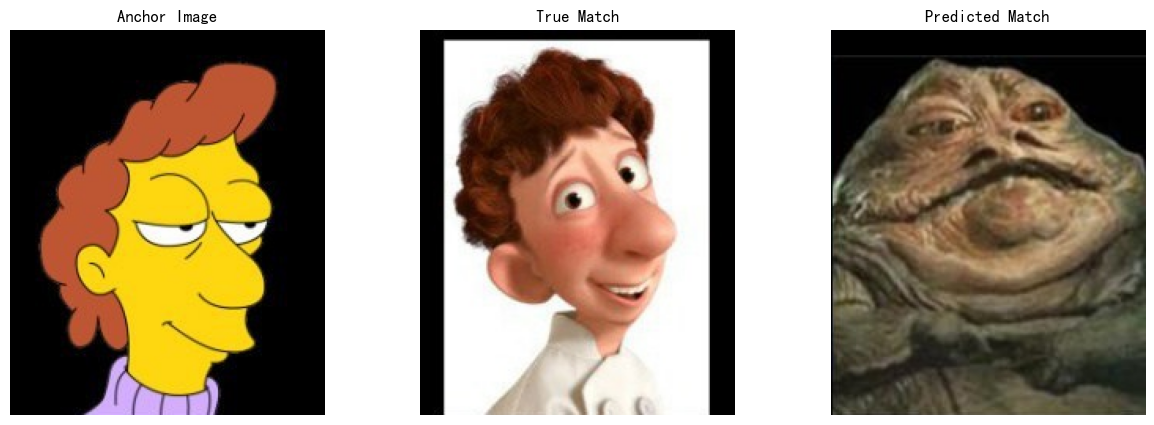

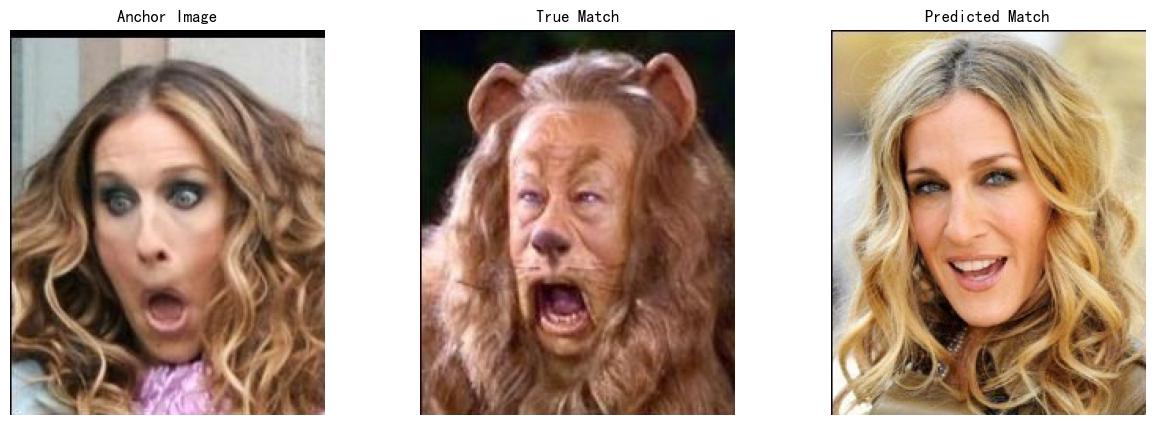

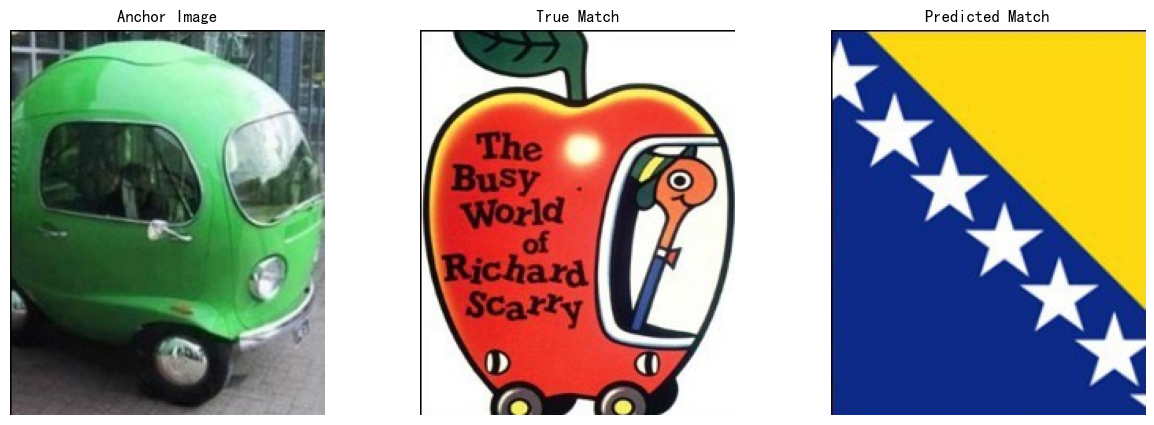

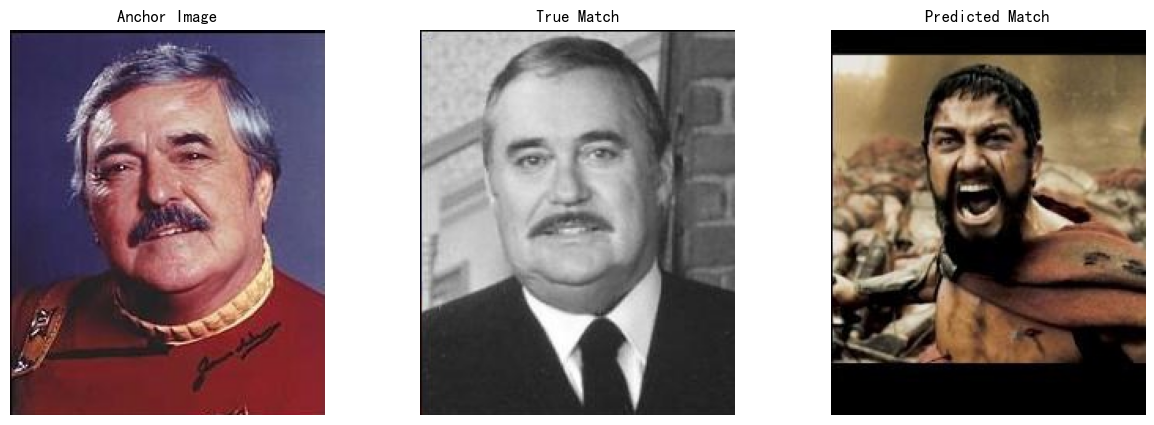

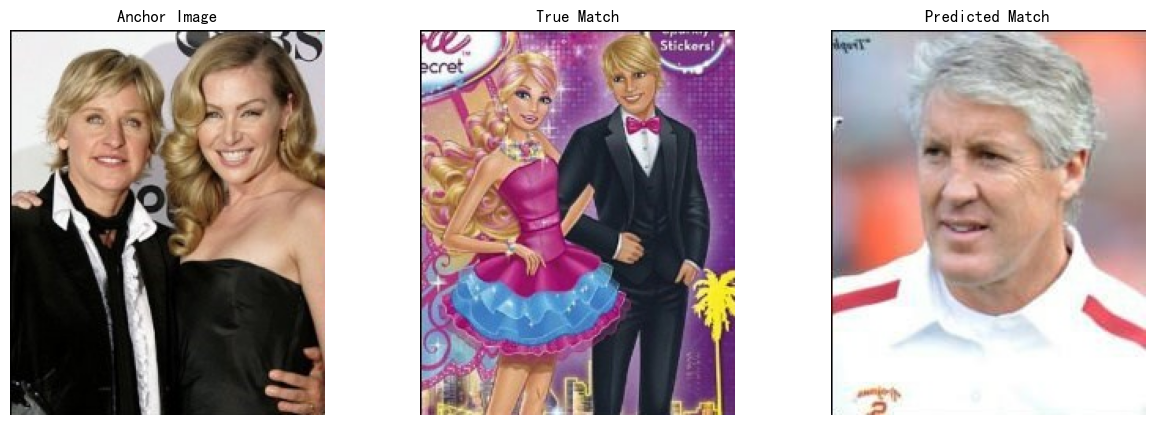

In [110]:
loaded_model = load_model("./saved_model/final_best_margin_1.h5", custom_objects={'custom_triplet_loss': custom_triplet_loss})
embedding_model = get_embedding_model_from_triplet(loaded_model)
accuracy, incorrect_preds = compute_test_accuracy_with_picture(embedding_model, test_data, left_dir, right_dir)
print(f"Accuracy: {accuracy:.2%}")
plot_incorrect_predictions(incorrect_preds, n=5)

In [112]:
import cv2
import numpy as np

from scipy.special import softmax
triplet_model = load_model("./saved_model/final_best_margin_1.h5", custom_objects={'custom_triplet_loss': custom_triplet_loss})
embedding_model = get_embedding_model_from_triplet(triplet_model)
test_candidates_data =pd.read_csv('./test_candidates.csv')

left_dir = './test/left'
right_dir = './test/right'
# Example usage
output_csv_path = './predicted_confidences2_10_19_margin_1_final.csv'
generate_confidence_csv(embedding_model, test_candidates_data, left_dir, right_dir, output_csv_path)


Processing rows: 100%|██████████| 2000/2000 [07:07<00:00,  4.68it/s]


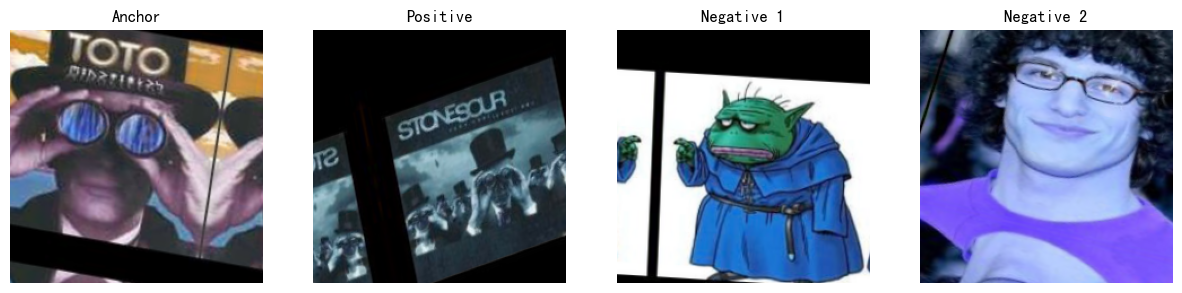

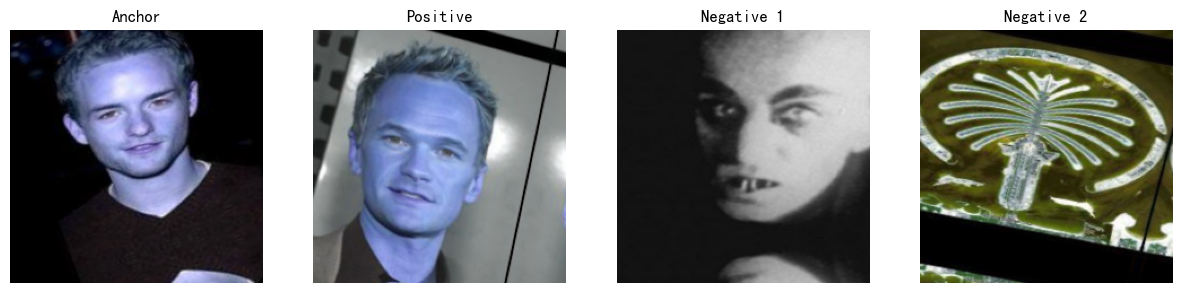

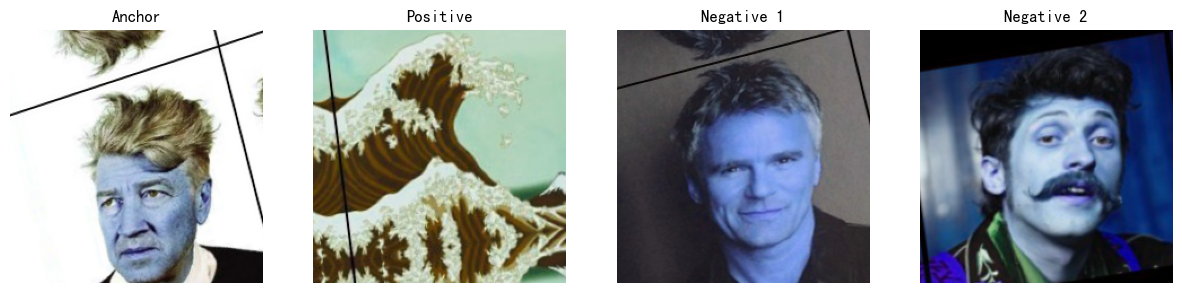

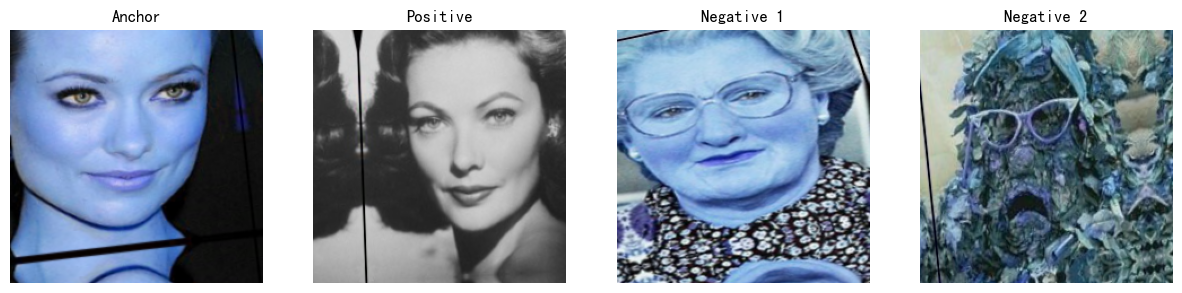

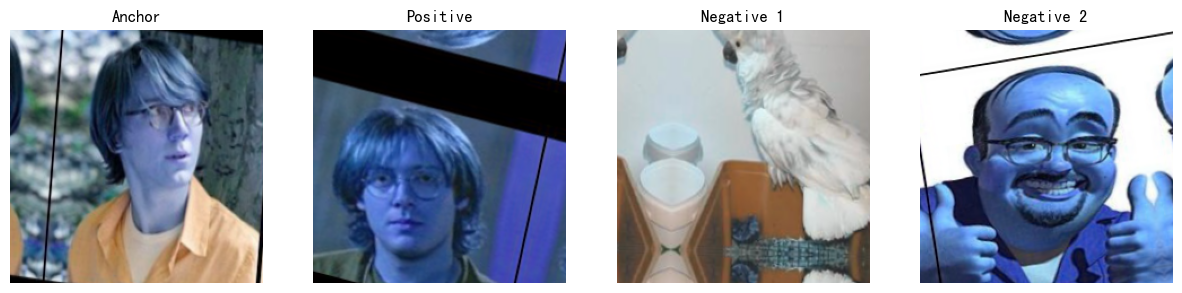

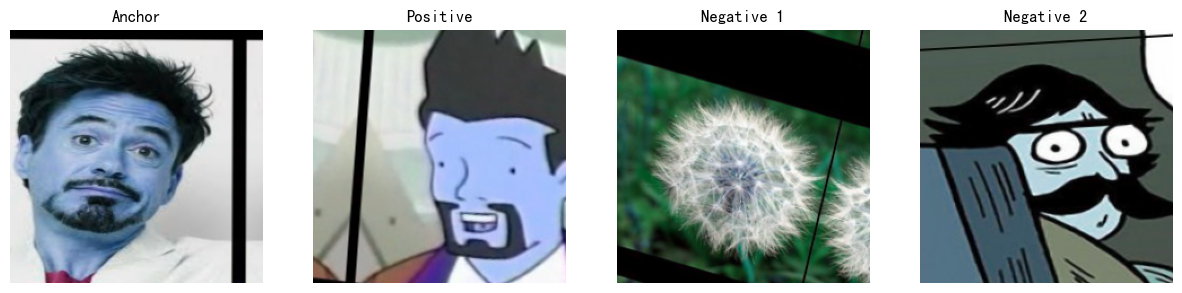

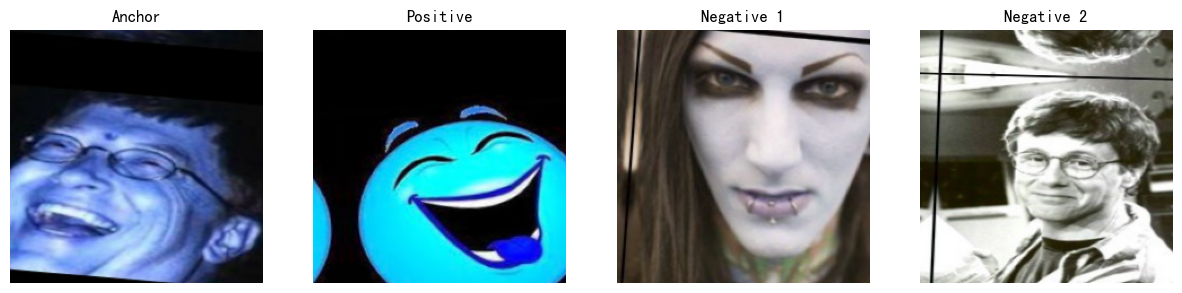

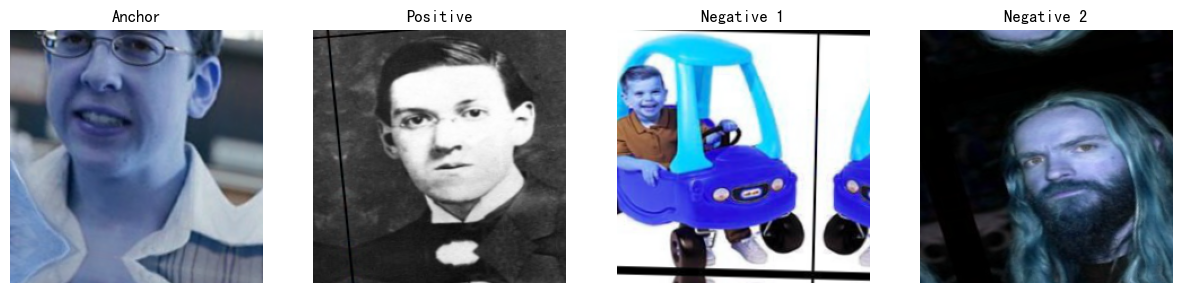

In [113]:
# viusualize the negatives
data, _ = train_generator[0]  
anchors, positives = data[0], data[1]
all_negatives = data[2:]


batch_size = anchors.shape[0]

for i in range(batch_size):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    
    axes[0].imshow(anchors[i])
    axes[0].set_title('Anchor')
    axes[0].axis('off')
    
    axes[1].imshow(positives[i])
    axes[1].set_title('Positive')
    axes[1].axis('off')
    
    for j in range(2):  
        axes[j + 2].imshow(all_negatives[j][i])
        axes[j + 2].set_title(f'Negative {j+1}')
        axes[j + 2].axis('off')
        
    plt.show()
